In [1]:
from brian2 import *
import matplotlib.pyplot as plt
from data_loader import load_pickle
from ADM import ADM
import seaborn as sns
sns.set()

In [74]:
def create_spike_generator(freq, duration):
    indices = []
    times = []
    timesteps = int(freq * duration / second)
    indices = np.zeros(timesteps)
    times = np.arange(0, duration / second, 1 / freq)

    return SpikeGeneratorGroup(1, indices, times * second)

In [126]:
LIF_neuron_model = {
    'model': '''
             dv/dt = (-v + R * I_syn_exc) / tau : volt
             tau : second
             R : ohm
             
             dI_syn_exc/dt = -I_syn_exc / tau_syn : amp
             tau_syn : second
             ''',
    'threshold': 'v > 1 * volt',
    'reset': 'v = 0 * volt'
}

exc_synapse_model = {
    'model': 'weight : 1',
    'on_pre': 'I_syn_exc_post += weight * amp'
}

In [127]:
device.reinit()
device.activate()
defaultclock.dt = 500 * us
duration = 2 * second

network = Network()

# create neurons, synapses
spike_generator = create_spike_generator(3, duration)
N = NeuronGroup(1, **LIF_neuron_model)
S = Synapses(spike_generator, N, **exc_synapse_model)
S.connect(True)

N.tau = 1 * second
N.R = 1 * ohm
N.tau_syn = 2 * second
N.I_syn_exc = 1 * amp
S.weight = 1

# create monitors
mon_synapse_state = StateMonitor(S, 'I_syn_exc', record=True)
mon_neuron_state  = StateMonitor(N,  'v', record=True)
mon_neuron_input  = SpikeMonitor(spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(N, name='mon_neuron_output')


# add elements to network
network.add([spike_generator, N, S,
             mon_synapse_state, mon_neuron_state, mon_neuron_input, mon_neuron_output])

# simulation
network.run(duration)

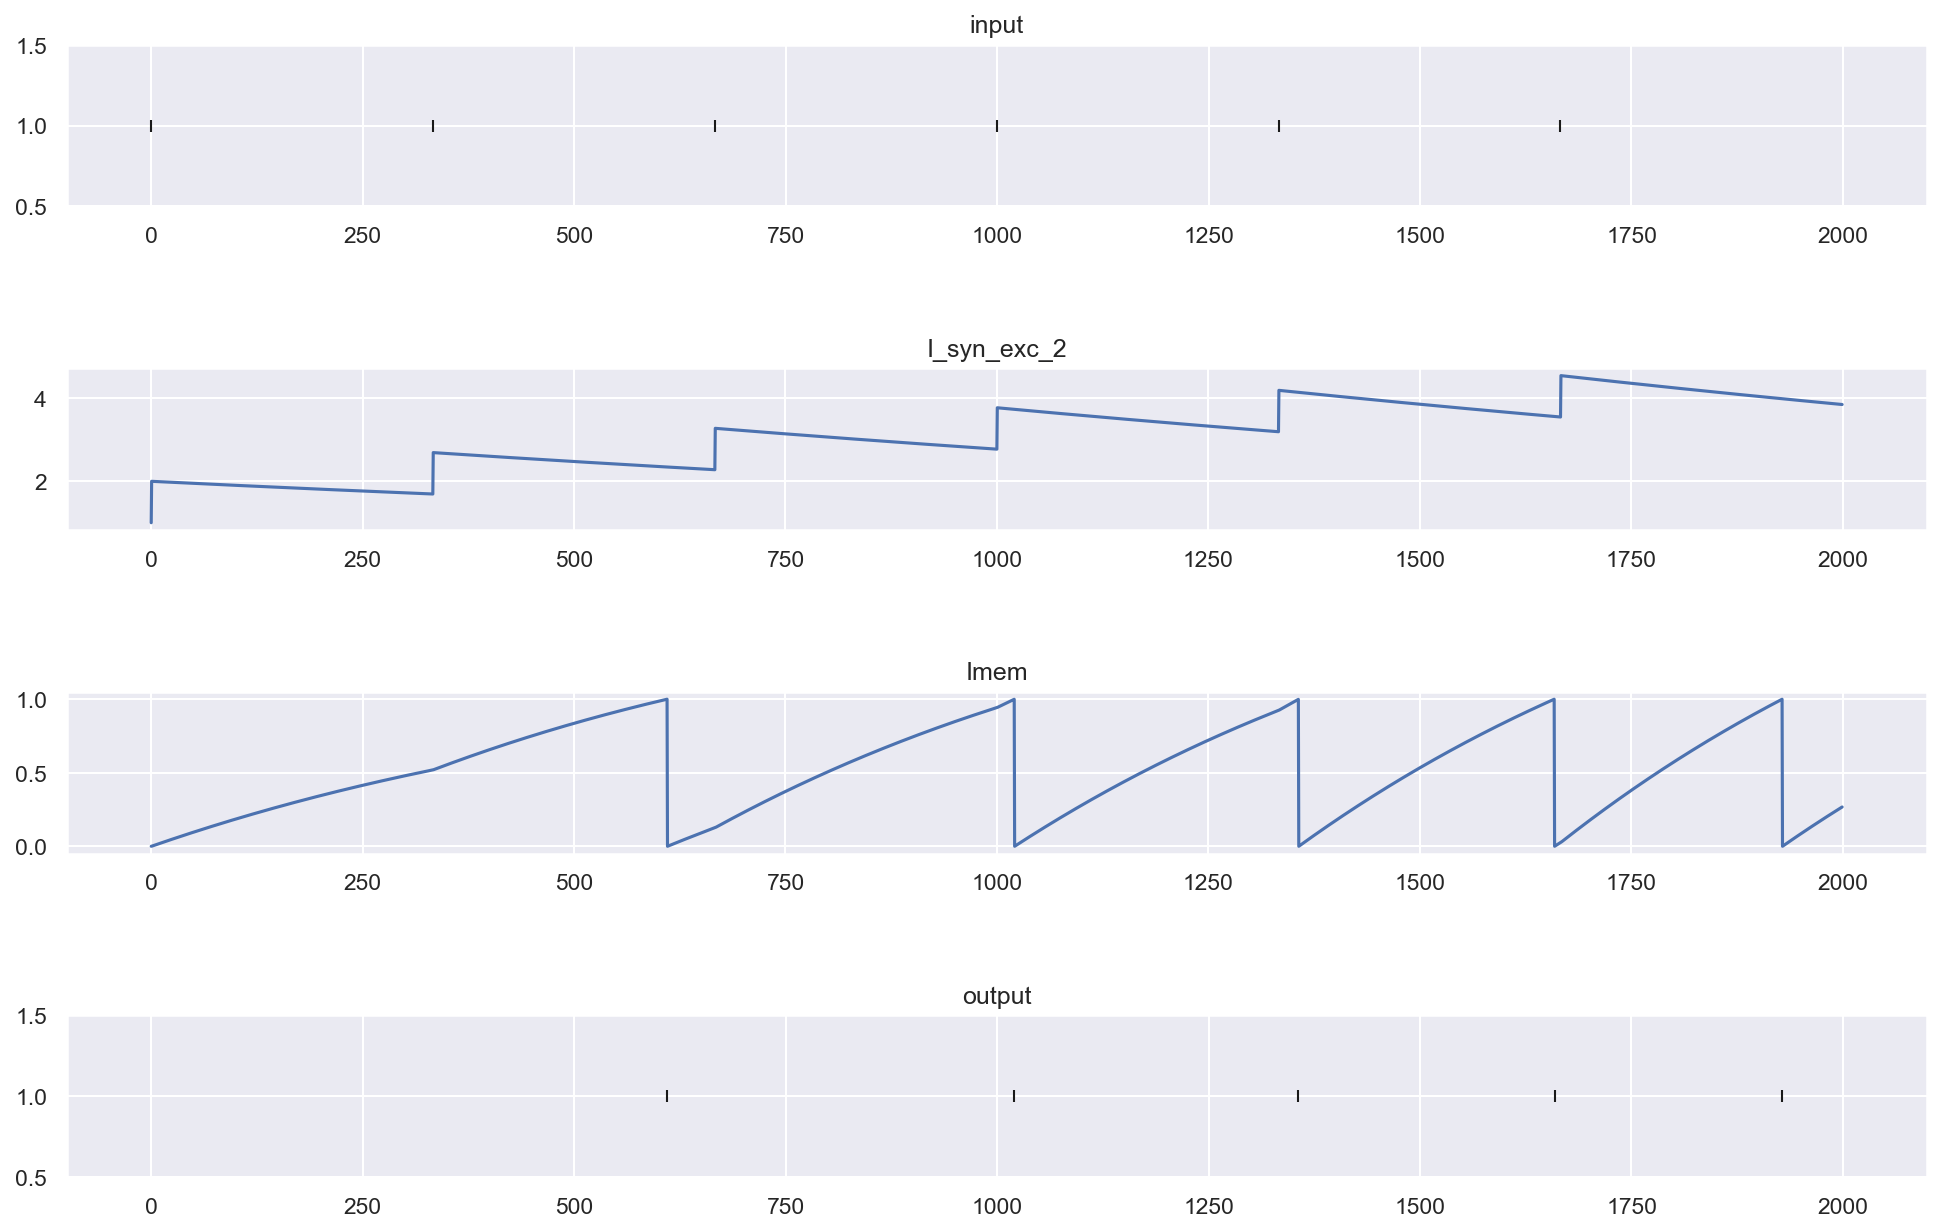

In [128]:
plt.figure(figsize=(16,10),dpi=150)
plt.subplots_adjust(hspace=1)

output_idx = 0

plt.subplot(411)
times = int(duration/ms)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
plt.ylim(0.5, 1.5)
plt.title('input')

plt.subplot(412)
plt.plot(mon_synapse_state.t / ms, mon_synapse_state.I_syn_exc[output_idx])
plt.title('I_syn_exc_2')

plt.subplot(413)
plt.plot(mon_neuron_state.t / ms, mon_neuron_state.v[output_idx])
plt.title('Imem')


plt.subplot(414)
times = int(duration/ms)
spike_placeholder = np.zeros(times)
relevant_timestamps = mon_neuron_output.t[mon_neuron_output.i == output_idx]
spike_placeholder[np.array(relevant_timestamps/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
plt.ylim(0.5, 1.5)
plt.title('output')



plt.show()